# Channel Flow (Steady) DEMO code

This notebook demonstrates solving steady-state channel flow (uniform inlet) using Physics-Informed Neural Networks (PINNs).

In [29]:
import deepflow as df
print("deepflow is currently run on:", df.device)

deepflow is currently run on: cuda


## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [30]:
rectangle = df.geometry.rectangle([0,1], [0,1])

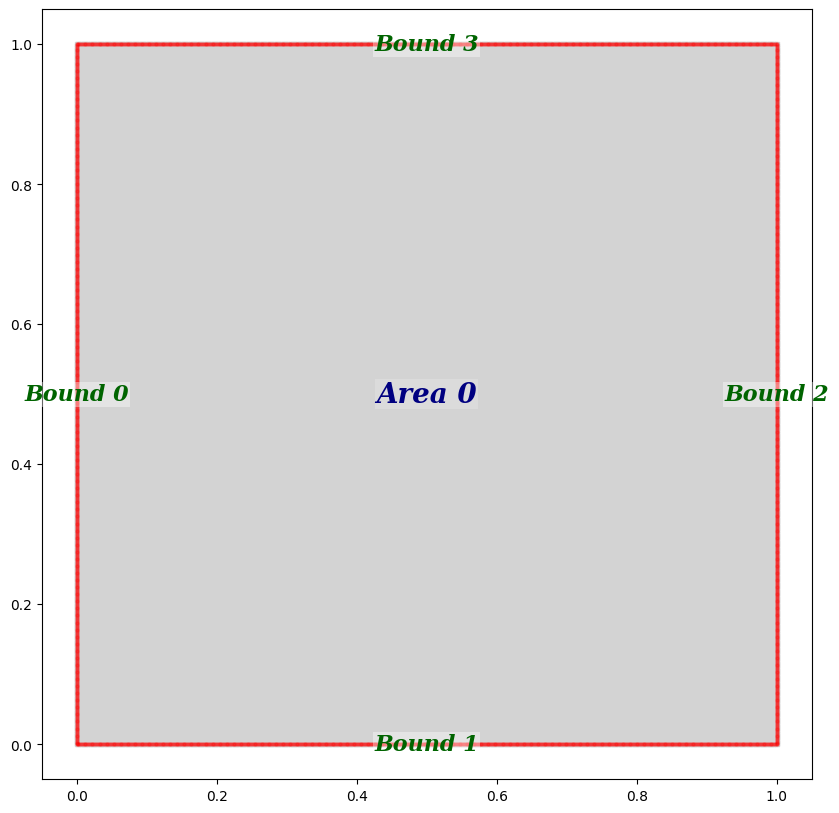

In [31]:
domain = df.domain(rectangle.bound_list, rectangle)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

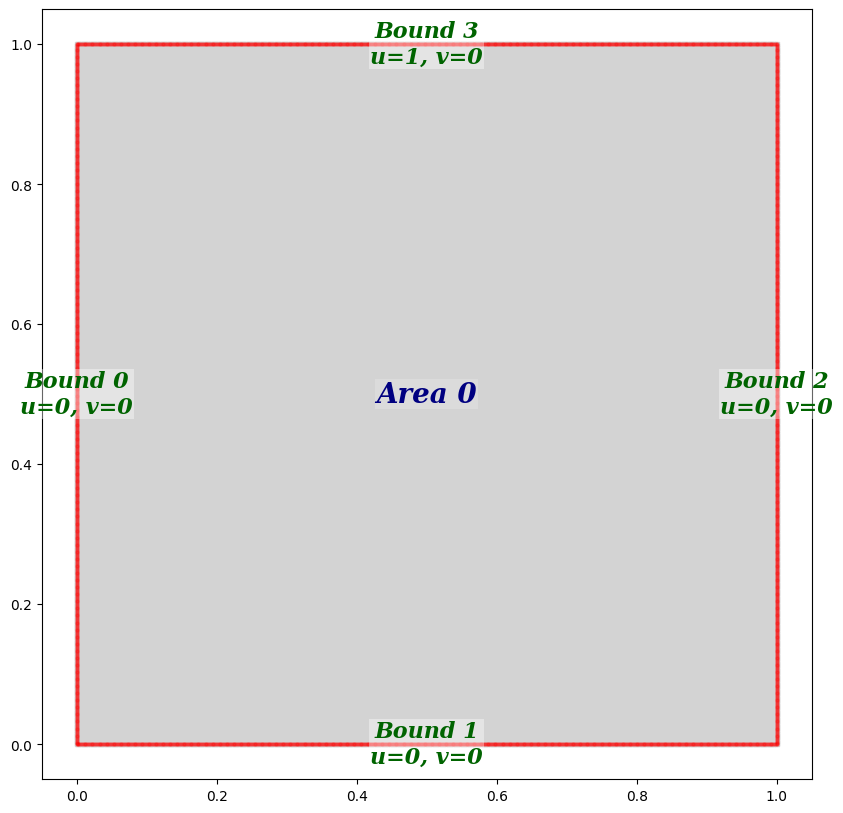

In [32]:
domain.bound_list[0].define_bc({'u':0,'v':0})
domain.bound_list[1].define_bc({'u':0,'v':0})
domain.bound_list[2].define_bc({'u':0,'v':0})
domain.bound_list[3].define_bc({'u':1,'v':0})
domain.area_list[0].define_pde(df.pde.NavierStokes(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


Sample initial points for training. Required if using Residual-based Adaptive Refinement (RAR).

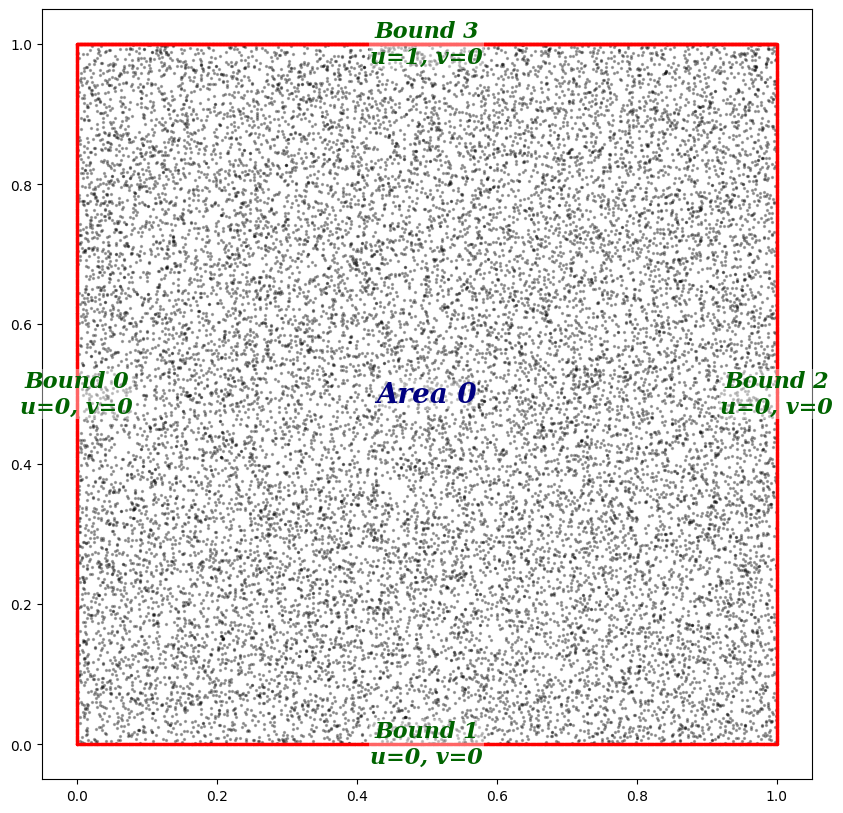

In [33]:
domain.sampling_uniform(bound_sampling_res=[2000, 2000, 2000, 4000])
domain.sampling_random(area_sampling_res=[20000])
domain.show_coordinates(display_conditions=True)

## 3. Train the PINN model
Initialize a PINN with specified width and depth.

In [34]:
model0 = df.PINN(width=50, length=5)

Design how to compute loss from boundary conditions and PDE residuals

In [35]:
# Define the loss calculation function
N=0
def calc_loss(model):
    global N
    N+=1
    if N%250==0:
        domain.sampling_random(area_sampling_res=[20000])

    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        bc_loss += bc.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = bc_loss + 10*pde_loss # weight bc_loss more

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss} # MUST RETURN IN THIS FORMAT)

Train the model using Adam for initial training (faster convergence).

In [36]:
# Train the model
model1, model1best = model0.train_adam(
    calc_loss=calc_loss,
    learning_rate=0.001,
    epochs=2000,
    print_every=200,
    threshold_loss=0.01,
)

Epoch: 1, total_loss: 1.16666, bc_loss: 1.15914, pde_loss: 0.00075
Epoch: 200, total_loss: 0.10955, bc_loss: 0.09933, pde_loss: 0.00102
Epoch: 400, total_loss: 0.09561, bc_loss: 0.08717, pde_loss: 0.00084
Epoch: 600, total_loss: 0.08890, bc_loss: 0.08324, pde_loss: 0.00057
Epoch: 800, total_loss: 0.08339, bc_loss: 0.07661, pde_loss: 0.00068
Epoch: 1000, total_loss: 0.08261, bc_loss: 0.07207, pde_loss: 0.00105
Epoch: 1200, total_loss: 0.07921, bc_loss: 0.07107, pde_loss: 0.00081
Epoch: 1400, total_loss: 0.07762, bc_loss: 0.07189, pde_loss: 0.00057
Epoch: 1600, total_loss: 0.07652, bc_loss: 0.06999, pde_loss: 0.00065
Epoch: 1800, total_loss: 0.07546, bc_loss: 0.06974, pde_loss: 0.00057
Epoch: 2000, total_loss: 0.07576, bc_loss: 0.06612, pde_loss: 0.00096


Refine the model using LBFGS for higher precision.

In [37]:
# Define the loss calculation function
def calc_loss(model):

    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        bc_loss += bc.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = bc_loss + 10*pde_loss # weight bc_loss more

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss} # MUST RETURN IN THIS FORMAT)

In [38]:
# Train the model
model2 = model1best.train_lbfgs(
    calc_loss=calc_loss,
    epochs=500,
    print_every=50,
    threshold_loss=0.001)

Epoch: 1976, total_loss: 0.07245, bc_loss: 0.06804, pde_loss: 0.00044
Epoch: 2026, total_loss: 0.02966, bc_loss: 0.02373, pde_loss: 0.00059
Epoch: 2076, total_loss: 0.01253, bc_loss: 0.01086, pde_loss: 0.00017
Epoch: 2126, total_loss: 0.00880, bc_loss: 0.00743, pde_loss: 0.00014
Epoch: 2176, total_loss: 0.00622, bc_loss: 0.00519, pde_loss: 0.00010
Epoch: 2226, total_loss: 0.00495, bc_loss: 0.00415, pde_loss: 0.00008
Epoch: 2276, total_loss: 0.00419, bc_loss: 0.00349, pde_loss: 0.00007
Epoch: 2326, total_loss: 0.00382, bc_loss: 0.00314, pde_loss: 0.00007
Epoch: 2376, total_loss: 0.00354, bc_loss: 0.00292, pde_loss: 0.00006
Epoch: 2426, total_loss: 0.00327, bc_loss: 0.00271, pde_loss: 0.00006


Save or Load the model for later use

In [39]:
model2.save_as_pickle("cavity_flow_model.pkl")

Show the final sampled points used in training

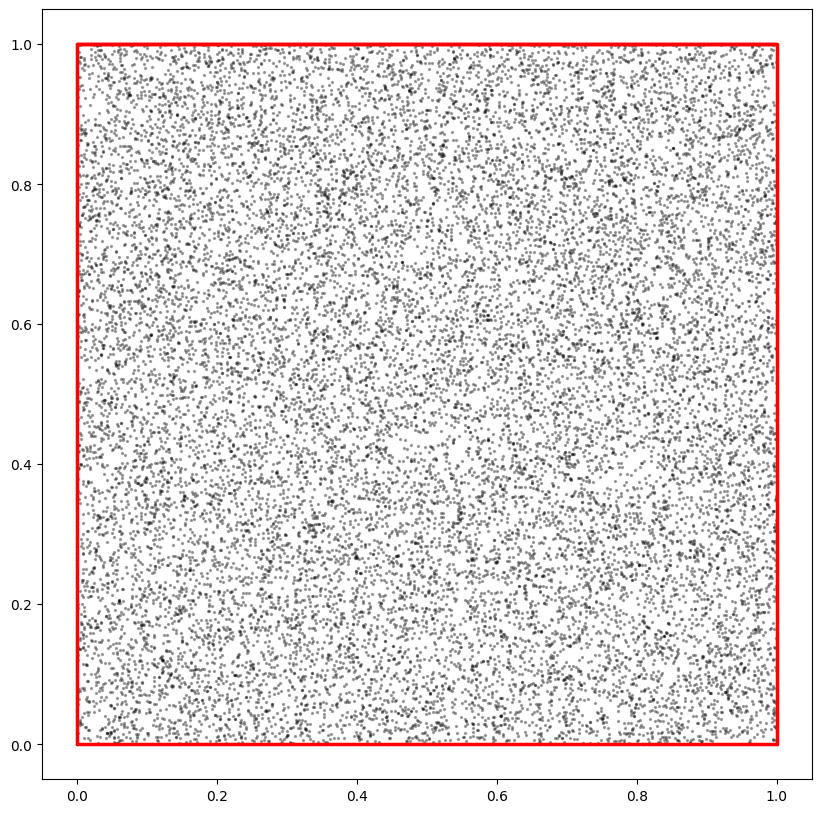

number of bound : ['0: 2000', '1: 2000', '2: 2000', '3: 4000']

        number of area : ['0: 20000']


In [40]:
domain.show_coordinates()
print(domain)

## 4. Visualization

### 4.1 Visualize area

In [41]:
area_eval = domain.area_list[0].evaluate(model2) # Create object for evaluation (Need Model and Geometry)
area_eval.sampling_area([200, 200]) # Sampling uniform points

Available data keys: ('u', 'v', 'p', 'PDE residual', 'x', 'y', 'u_x', 'u_y', 'v_x', 'v_y', 'p_x', 'p_y', 'continuity_residual', 'x_momentum_residual', 'y_momentum_residual', 'total_loss', 'bc_loss', 'pde_loss')


In [42]:
area_eval['velocity_magnitude'] = (area_eval['u']**2 + area_eval['v']**2)**0.5

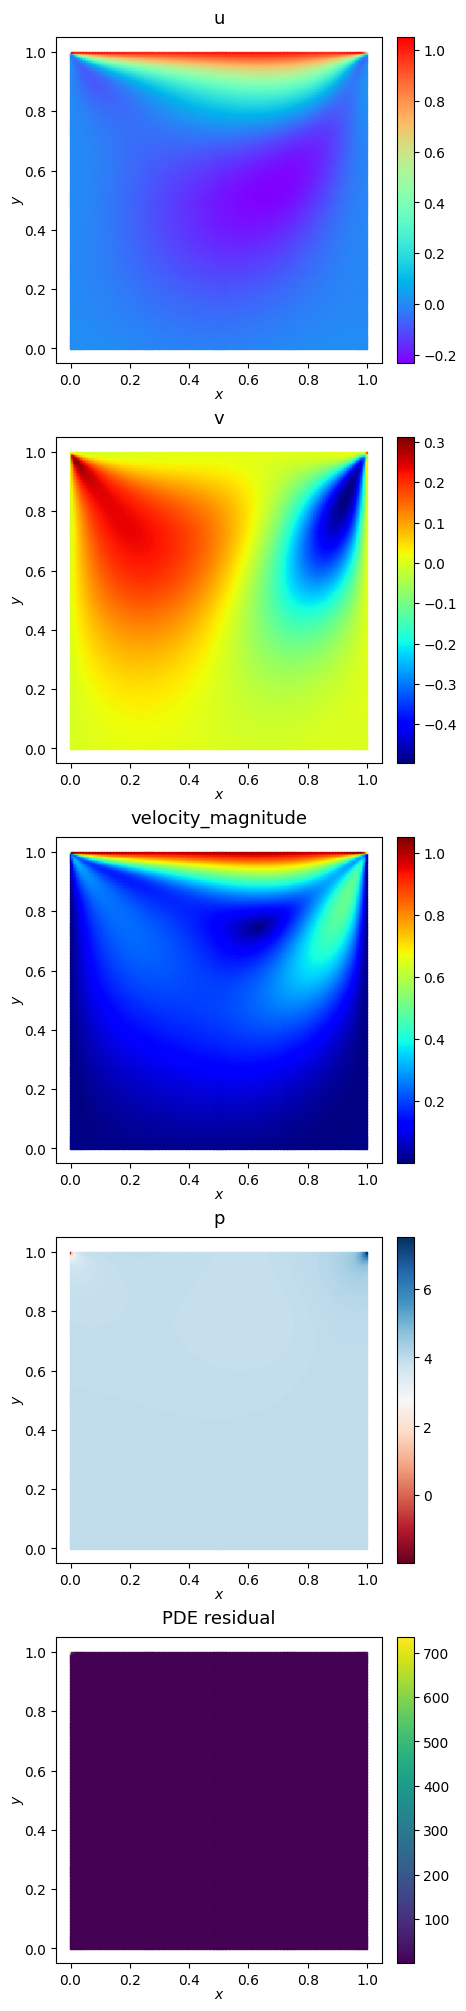

In [43]:
cmap_dict = {
    'u':'rainbow',
    'v':'jet',
    'velocity_magnitude': 'jet',
    'p':'RdBu',
    'PDE residual': 'viridis'
}
colorplot_area_2d = area_eval.plot_color(cmap_dict, s=0.6).savefig('colorplot_area_2d.png')

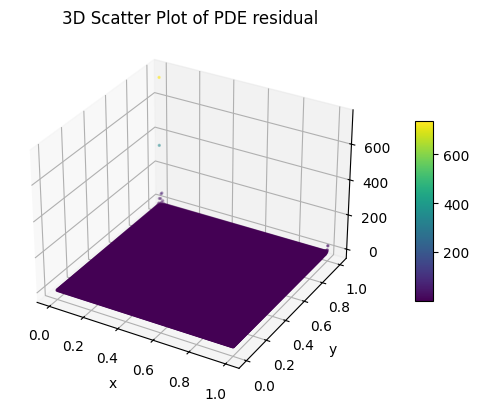

In [44]:
area_eval.plot('PDE residual').savefig('residual_plot_3d.png')

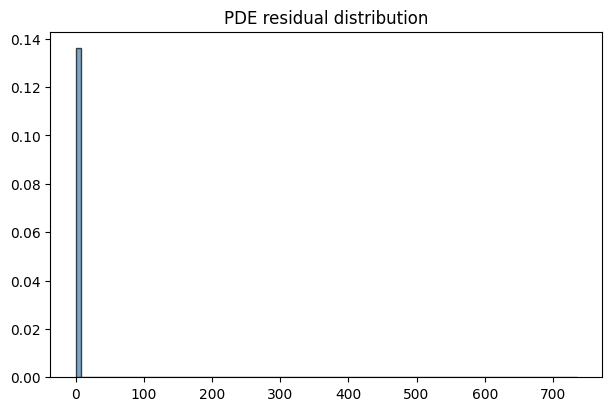

In [45]:
residual_destribution = area_eval.plot_distribution('PDE residual', bins=100)

### 4.2 Visualize bound

In [46]:
# Create object for evaluation (Need Model and Geometry)
bound_eval = domain.bound_list[3].evaluate(model2)
# Sampling uniform points
bound_eval.sampling_line(500)

Available data keys: ('u', 'v', 'p', 'BC residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


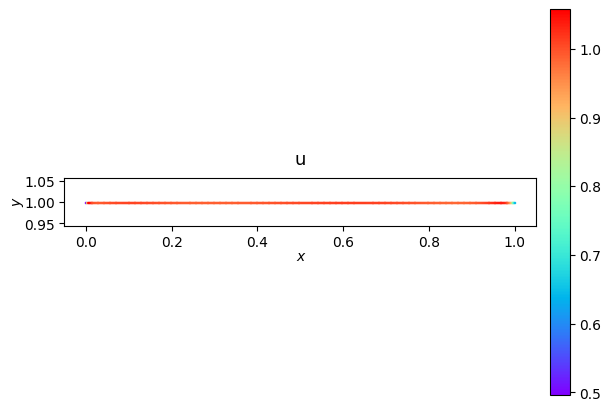

In [47]:
bound_eval.plot_color({'u':'rainbow'}, s=0.5).savefig('colorplot_bound_2d.png')

## 4.3 Visualize Neural Network data

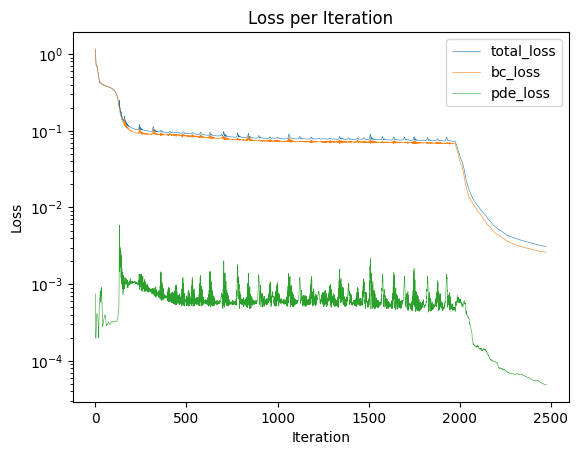

In [48]:
loss_history = bound_eval.plot_loss_curve(log_scale=True, linewidth=0.4)
loss_history.savefig('loss_history.png')

### 4.4 Export data

In [49]:
# store the x,y,velocity_magnitude data
x_data = bound_eval['x']
y_data = bound_eval['y']
u_data = bound_eval['u']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, u_data))
np.savetxt('outlet_velocity_profile.txt', array)